# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa.display
import librosa.feature
import librosa.onset
from madmom.features import notes, key, chords

from sklearn.decomposition import PCA

from src.helpers import *

Had to perform the following to get `librosa.load()` to work properly after encountering `Error 0x7e: cannot load sndfile.dll`
```sh
pip uninstall soundfile
pip install soundfile
```

# Read Data

In [3]:
raw_audio_handler = RawAudioHandler('../../data/playlist-1', limit=3)
print(raw_audio_handler.audio_files)
raw_audio = raw_audio_handler.load()

['../../data/playlist-1\\Bruno Major - Easily.mp3', '../../data/playlist-1\\Bruno Major - Nothing.mp3', '../../data/playlist-1\\Bruno Major - The Most Beautiful Thing.mp3']


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [ ]:
raw_audio

In [818]:
def extract_features(filepath, n_mels=256):

    # Load data
    waveform, sample_rate = librosa.load(filepath)

    # Generate spectrogram
    stft_data = librosa.stft(waveform)
    spectrogram = librosa.amplitude_to_db(np.abs(stft_data), ref=np.max)

    # Generate mel spectrogram
    mel_data = librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=n_mels)
    mel_spectrogram = librosa.amplitude_to_db(np.abs(mel_data), ref=np.max)

    return waveform, sample_rate, spectrogram, mel_spectrogram

In [819]:
waveform, sample_rate, spectrogram, mel_spectrogram = extract_features(audio_files[4])

# Visualising the Input Data

## Waveform

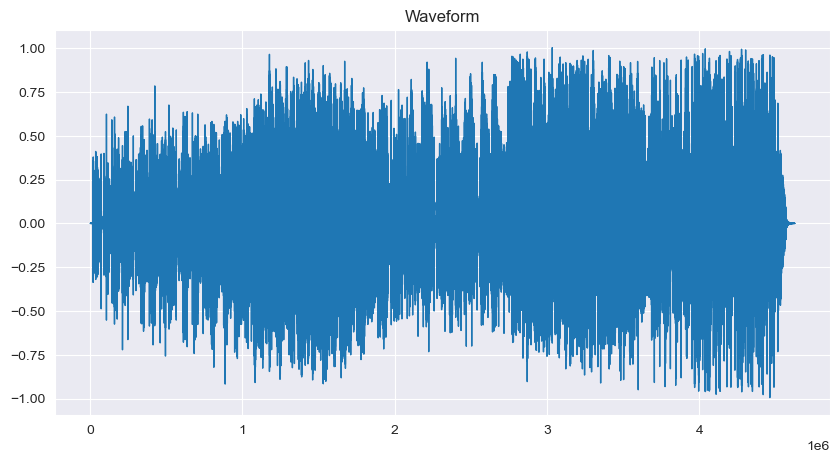

In [820]:
pd.Series(waveform).plot(figsize=(10,5), lw=1, title='Waveform')
plt.show()

## Spectrogram

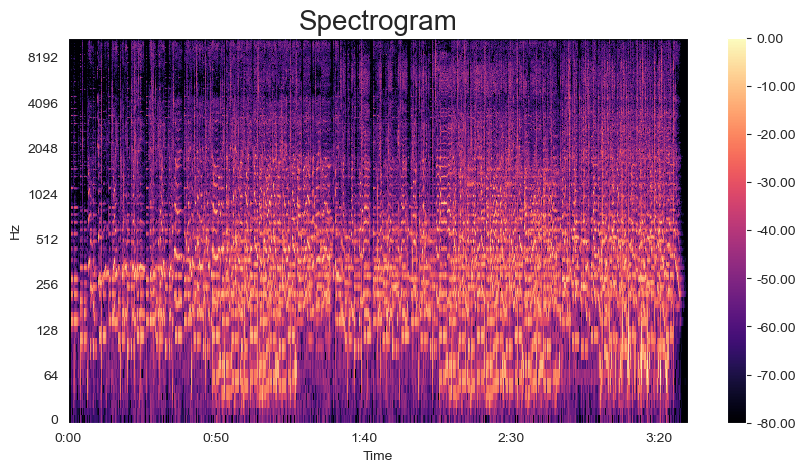

In [821]:
# Plot data
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(spectrogram, x_axis='time', y_axis='log', ax=ax)
ax.set_title('Spectrogram', fontsize=20)
fig.colorbar(img, ax=ax, format='%0.2f')
plt.show()

## Mel Spectrogram

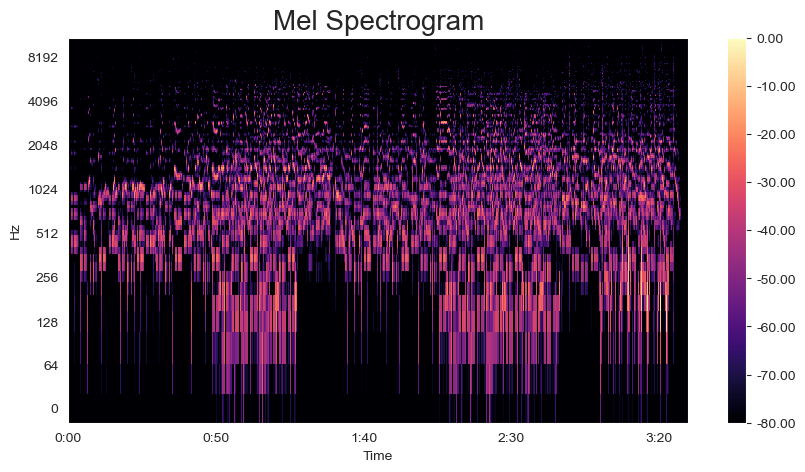

In [822]:
# Plot data
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='log', ax=ax)
ax.set_title('Mel Spectrogram', fontsize=20)
fig.colorbar(img, ax=ax, format='%0.2f')
plt.show()

# Timbral Texture Feature Extraction

## Spectral Centroid

In [823]:
# Spectral centroid
spectral_centroid = librosa.feature.spectral_centroid(y=waveform, sr=sample_rate)
spectral_centroid.mean(), spectral_centroid.var()

(1931.0932523562055, 583355.8620353352)

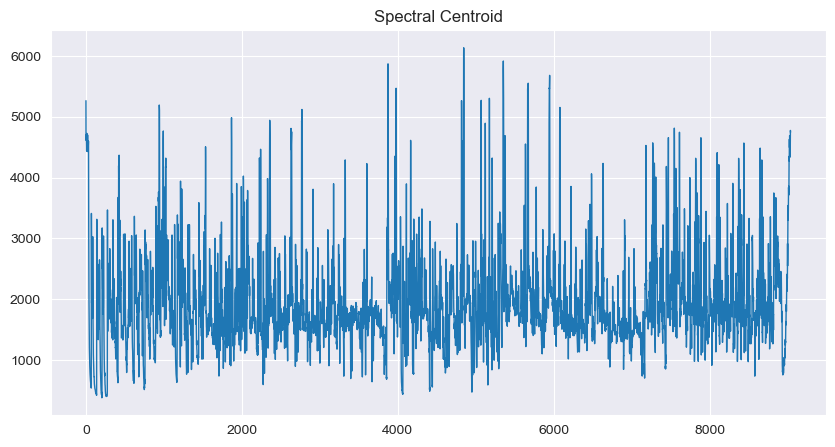

In [824]:
pd.Series(spectral_centroid[0]).plot(figsize=(10,5), lw=1, title='Spectral Centroid')
plt.show()

## Spectral Rolloff

In [825]:
# Spectral rolloff
spectral_rolloff = librosa.feature.spectral_rolloff(y=waveform, sr=sample_rate)
spectral_rolloff.mean(), spectral_rolloff.var()

(4200.484101925591, 3314214.6686632116)

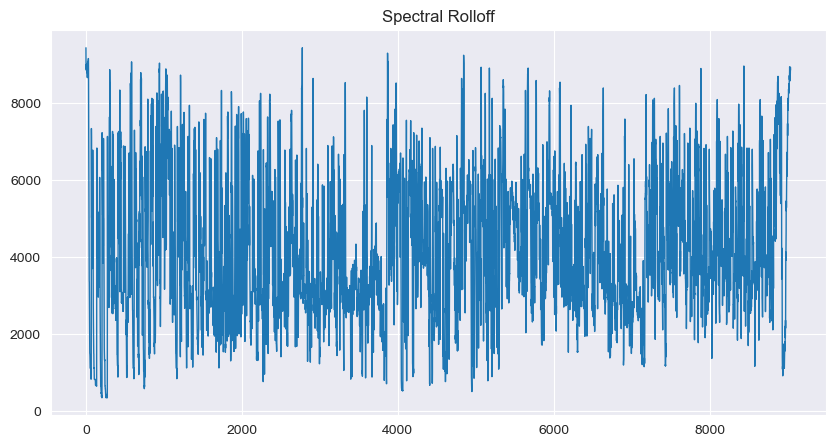

In [826]:
pd.Series(spectral_rolloff[0]).plot(figsize=(10,5), lw=1, title='Spectral Rolloff')
plt.show()

## Spectral Flux

In [827]:
# Spectral flux
# squared distance between normalised magnitudes of successive spectral distributions
spectral_flux = librosa.onset.onset_strength(y=waveform, sr=sample_rate)
spectral_flux.mean(), spectral_flux.var()

(1.2475342, 1.7504435)

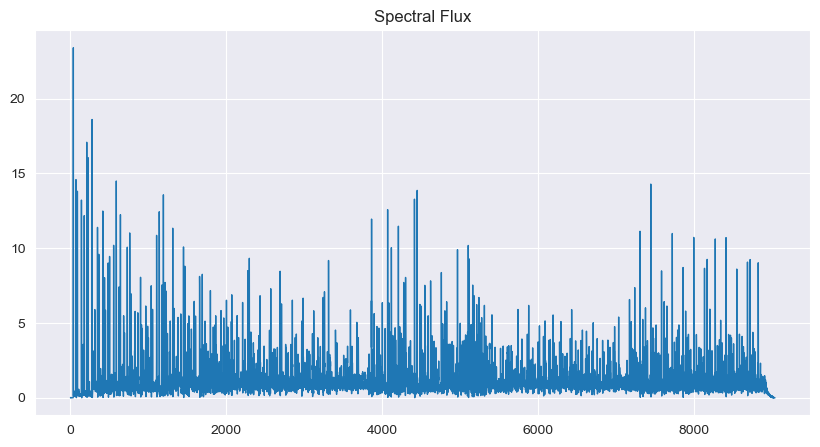

In [828]:
pd.Series(spectral_flux).plot(figsize=(10,5), lw=1, title='Spectral Flux')
plt.show()

## Time Domain Zero Crossings

In [829]:
zero_crossings = librosa.zero_crossings(y=waveform)
zero_crossings.mean(), zero_crossings.var()

(0.07163257022489516, 0.06650134510787062)

In [830]:
zero_crossings
# might not be exactly the same as Tzanetakis' implementation

array([ True,  True,  True, ..., False,  True, False])

## MFCC Extraction

13 MFCC coefficients, and using only the first 5 excluding DC component

In [831]:
cepstral_coefficients = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=13)
cepstral_coefficients_df = pd.DataFrame(cepstral_coefficients[1:6]).transpose()

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

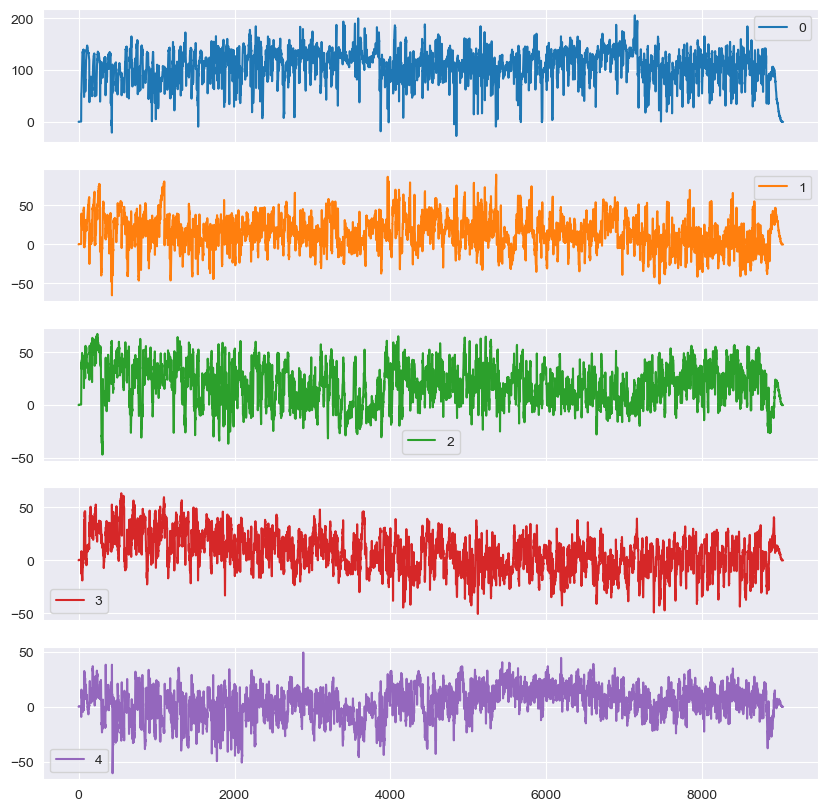

In [832]:
cepstral_coefficients_df.plot(subplots=True, figsize=(10,10))

In [833]:
cepstral_coefficients_df.mean()

0    107.245453
1     14.395954
2     18.686554
3      6.706423
4      3.488143
dtype: float32

In [834]:
cepstral_coefficients_df.var()

0    1037.460205
1     425.557648
2     338.875702
3     310.433258
4     212.071335
dtype: float32

# Chord Trajectory

In [835]:
# CQT used for harmonic content over STFT for rhythmic content
chroma_cqt = librosa.feature.chroma_cqt(y=waveform, sr=sample_rate)
chroma_cqt

array([[0.12039527, 0.15373456, 0.17816749, ..., 0.20938602, 0.23515113,
        0.2515021 ],
       [0.13281538, 0.14790668, 0.18634635, ..., 0.21875975, 0.25723958,
        0.2888599 ],
       [0.28908652, 0.30752528, 0.36527273, ..., 0.4458725 , 0.46585914,
        0.44173014],
       ...,
       [0.3264691 , 0.33129364, 0.3273883 , ..., 0.4604805 , 0.45033613,
        0.43636757],
       [0.17202497, 0.18605438, 0.1717031 , ..., 0.52431315, 0.4851407 ,
        0.4481093 ],
       [0.1308656 , 0.19589421, 0.2709792 , ..., 0.4295813 , 0.45475245,
        0.4273225 ]], dtype=float32)

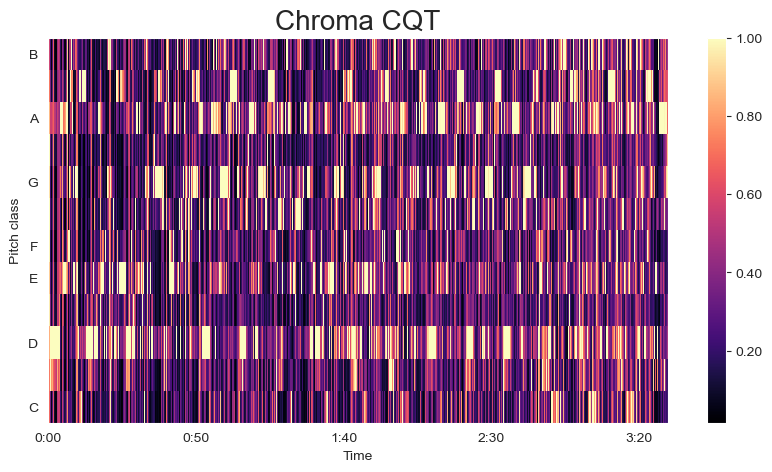

In [836]:
# Plot data
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(chroma_cqt, x_axis='time', y_axis='chroma', ax=ax)
ax.set_title('Chroma CQT', fontsize=20)
fig.colorbar(img, ax=ax, format='%0.2f')
plt.show()

In [837]:
bpm, beat_frames = librosa.beat.beat_track(y=waveform, sr=sample_rate)
beat_frames

array([  19,   37,   54,   71,   89,  106,  123,  141,  159,  177,  193,
        209,  227,  243,  260,  277,  295,  313,  330,  347,  364,  381,
        398,  415,  434,  449,  466,  484,  502,  519,  536,  554,  571,
        588,  605,  623,  641,  658,  675,  693,  711,  729,  745,  761,
        779,  795,  812,  829,  847,  864,  881,  899,  916,  933,  950,
        966,  983, 1000, 1018, 1036, 1053, 1070, 1087, 1105, 1122, 1139,
       1156, 1174, 1192, 1211, 1229, 1245, 1262, 1280, 1296, 1312, 1330,
       1346, 1363, 1380, 1398, 1415, 1432, 1450, 1467, 1484, 1501, 1518,
       1534, 1552, 1569, 1587, 1604, 1621, 1639, 1657, 1675, 1691, 1710,
       1726, 1743, 1760, 1778, 1795, 1814, 1832, 1848, 1864, 1881, 1898,
       1915, 1932, 1950, 1967, 1984, 2001, 2018, 2034, 2052, 2069, 2086,
       2103, 2121, 2138, 2156, 2174, 2191, 2208, 2225, 2242, 2259, 2277,
       2294, 2312, 2329, 2347, 2364, 2381, 2398, 2415, 2433, 2450, 2466,
       2483, 2501, 2518, 2535, 2552, 2569, 2586, 26

In [838]:
# np.max to get most prominent notes
chroma_sync = librosa.util.sync(chroma_cqt, beat_frames, aggregate=np.max)
chroma_sync

array([[0.7880648 , 1.        , 0.24708718, ..., 0.5624891 , 0.682747  ,
        1.        ],
       [0.95118505, 1.        , 1.        , ..., 0.276307  , 0.6962686 ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.9076668 , 0.81040865,
        1.        ],
       ...,
       [0.7961401 , 0.9792123 , 0.6067213 , ..., 0.54656506, 0.562294  ,
        1.        ],
       [0.6454462 , 0.9850955 , 0.30134714, ..., 1.        , 1.        ,
        1.        ],
       [0.8909823 , 0.96688855, 0.18356083, ..., 0.49611467, 0.6858157 ,
        1.        ]], dtype=float32)

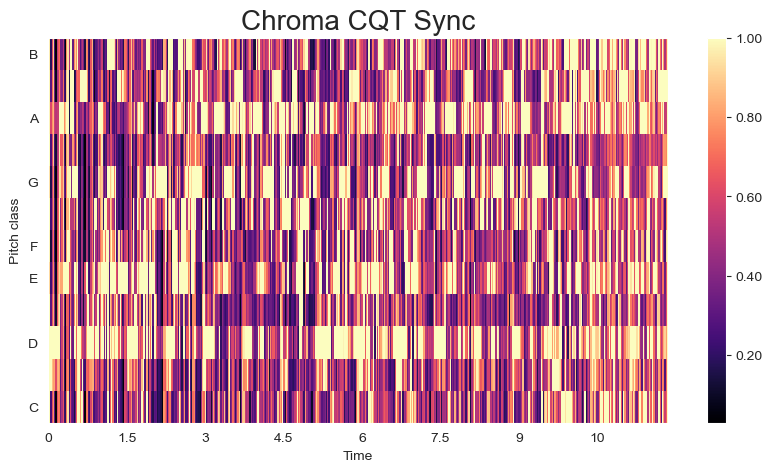

In [839]:
# Plot data
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(chroma_sync, x_axis='time', y_axis='chroma', ax=ax)
ax.set_title('Chroma CQT Sync', fontsize=20)
fig.colorbar(img, ax=ax, format='%0.2f')
plt.show()

In [840]:
tonnetz = librosa.feature.tonnetz(sr=sample_rate, chroma=chroma_sync)
tonnetz

array([[ 4.67512229e-03, -9.19564794e-03,  1.03741009e-01, ...,
         2.97692407e-02, -3.21080898e-02,  7.21644966e-16],
       [-3.15885559e-03, -8.52167534e-04, -7.71598868e-02, ...,
         1.63869352e-01,  6.66305253e-02, -1.38777878e-16],
       [ 2.44781524e-02, -4.13555652e-03, -2.32941713e-01, ...,
         1.19897719e-01,  1.39741972e-02, -5.00270451e-16],
       [ 3.02968398e-02, -5.17290831e-03, -1.70358509e-01, ...,
        -6.79078102e-02, -5.14617041e-02, -5.00270451e-16],
       [-1.11516950e-02, -3.45607541e-03,  1.05096594e-02, ...,
         1.24587529e-02,  7.75973704e-03,  4.85722573e-17],
       [-1.54399797e-02,  3.44200805e-03, -2.58056950e-02, ...,
        -5.87385725e-02, -3.49823236e-02,  5.55111512e-17]])

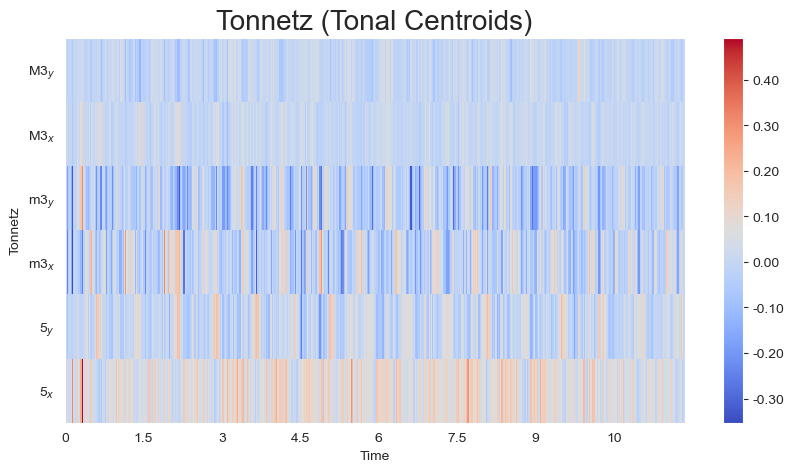

In [841]:
# Plot data
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(tonnetz, x_axis='time', y_axis='tonnetz', ax=ax)
ax.set_title('Tonnetz (Tonal Centroids)', fontsize=20)
fig.colorbar(img, ax=ax, format='%0.2f')
plt.show()

In [842]:
decode = chords.DeepChromaChordRecognitionProcessor(fps=sample_rate/512)
chords = decode(chroma_cqt.T)

In [843]:
chords

array([(0.00000000e+00, 2.08979592e-01, 'N'),
       (2.08979592e-01, 6.43192744e+00, 'A:maj'),
       (6.43192744e+00, 6.80344671e+00, 'D:maj'),
       (6.80344671e+00, 8.68426304e+00, 'N'),
       (8.68426304e+00, 1.01006803e+01, 'A:maj'),
       (1.01006803e+01, 1.03793197e+01, 'N'),
       (1.03793197e+01, 1.12616780e+01, 'A#:maj'),
       (1.12616780e+01, 1.35836735e+01, 'N'),
       (1.35836735e+01, 1.84134240e+01, 'A:maj'),
       (1.84134240e+01, 1.98066213e+01, 'N'),
       (1.98066213e+01, 2.07586395e+01, 'G:maj'),
       (2.07586395e+01, 2.11301587e+01, 'A:maj'),
       (2.11301587e+01, 2.16642177e+01, 'G:maj'),
       (2.16642177e+01, 2.55419501e+01, 'N'),
       (2.55419501e+01, 3.15326984e+01, 'A:maj'),
       (3.15326984e+01, 3.26008163e+01, 'N'),
       (3.26008163e+01, 3.35528345e+01, 'G:maj'),
       (3.35528345e+01, 3.39243537e+01, 'A:maj'),
       (3.39243537e+01, 3.72448073e+01, 'N'),
       (3.72448073e+01, 3.82432653e+01, 'G:min'),
       (3.82432653e+01, 3.91024

In [844]:
beat_times = librosa.frames_to_time(beat_frames)

In [845]:
beat_times

array([  0.44117914,   0.85913832,   1.25387755,   1.64861678,
         2.06657596,   2.46131519,   2.85605442,   3.27401361,
         3.69197279,   4.10993197,   4.48145125,   4.85297052,
         5.27092971,   5.64244898,   6.03718821,   6.43192744,
         6.84988662,   7.2678458 ,   7.66258503,   8.05732426,
         8.45206349,   8.84680272,   9.24154195,   9.63628118,
        10.07746032,  10.42575964,  10.82049887,  11.23845805,
        11.65641723,  12.05115646,  12.44589569,  12.86385488,
        13.2585941 ,  13.65333333,  14.04807256,  14.46603175,
        14.88399093,  15.27873016,  15.67346939,  16.09142857,
        16.50938776,  16.92734694,  17.29886621,  17.67038549,
        18.08834467,  18.45986395,  18.85460317,  19.2493424 ,
        19.66730159,  20.06204082,  20.45678005,  20.87473923,
        21.26947846,  21.66421769,  22.05895692,  22.43047619,
        22.82521542,  23.21995465,  23.63791383,  24.05587302,
        24.45061224,  24.84535147,  25.2400907 ,  25.65

In [846]:
chord_map = {
    'A:maj': 0,
    'A#:maj': 1,
    'B:maj': 2,
    'C:maj': 3,
    'C#:maj': 4,
    'D:maj': 5,
    'D#:maj': 6,
    'E:maj': 7,
    'F:maj': 8,
    'F#:maj': 9,
    'G:maj': 10,
    'G#:maj': 11,
    'A:min': 12,
    'A#:min': 13,
    'B:min': 14,
    'C:min': 15,
    'C#:min': 16,
    'D:min': 17,
    'D#:min': 18,
    'E:min': 19,
    'F:min': 20,
    'F#:min': 21,
    'G:min': 22,
    'G#:min': 23,
    'N': 24,
}

In [847]:
start_idx, end_idx = 0, 0
test = beat_times.tolist()

for start_time, end_time, chord_label in chords:

    for enum, beat_time in enumerate(beat_times[start_idx:]):
        # get current index and set as end index, exclusive
        current_idx = enum + start_idx
        if beat_time < end_time:
            # exclude major minor indicator
            chord_note = chord_label.partition(':')[0]
            test[current_idx] = beat_time, chord_map[chord_label]
        else:
            break

    start_idx = current_idx

In [848]:
chord_occurrences = pd.DataFrame(test, columns=['beat_time', 'chord'])
chord_occurrences

,beat_time,chord
0,0.441179,0
1,0.859138,0
2,1.253878,0
3,1.648617,0
4,2.066576,0
...,...,...
505,203.221043,1
506,203.615782,8
507,204.033741,3
508,204.428481,22


In [849]:
chord_trajectory = np.zeros(shape=(25,25))
chord_trajectory

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [850]:
ignore_non_chords = True

for x in range(0, chord_occurrences.shape[0]-1):
    chord_x = chord_occurrences['chord'].iloc[x]
    chord_y = chord_occurrences['chord'].iloc[x+1]

    if ignore_non_chords:
        if chord_x == 24 and chord_y == 24:
            continue
        elif chord_x == 24 and chord_y != 24:
            chord_trajectory[chord_y, chord_y] += 1
        elif chord_x != 24 and chord_y == 24:
            chord_trajectory[chord_x, chord_x] += 1
        else:
            chord_trajectory[chord_y, chord_x] += 1
    else:
        chord_trajectory[chord_y, chord_x] += 1

chord_trajectory

array([[170.,   3.,   0.,   8.,   0.,   4.,   0.,   0.,   5.,   0.,   4.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [  1.,  23.,   0.,   1.,   0.,   1.,   0.,   1.,   3.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [  6.,   0.,   0.,  24.,   0.,   3.,   0.,   0.,   5.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [  7.,   0.,   0.,   0.,   0.,  40.,   0.,   0.,   2.,   0.,   6.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,  

<Axes: >

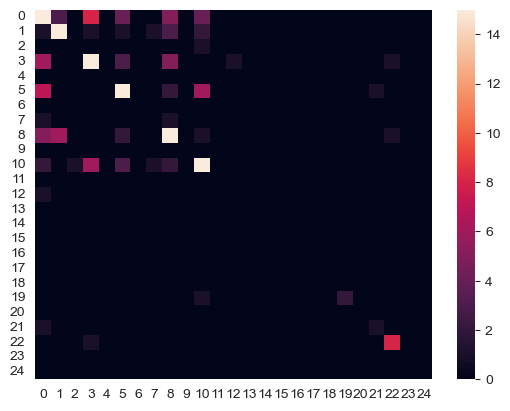

In [851]:
sns.heatmap(chord_trajectory, vmin=0, vmax=15)

In [852]:
key_proc = key.CNNKeyRecognitionProcessor()
global_key_prob = key_proc(waveform)
global_key_prob

array([[1.6323673e-04, 2.5294612e-03, 4.8517457e-05, 3.9199297e-04,
        3.3623859e-05, 9.8822635e-01, 7.6128395e-05, 8.6227752e-05,
        5.2167325e-05, 1.0405433e-03, 5.3645070e-03, 7.2356808e-05,
        2.5283225e-04, 3.5127112e-05, 1.3727964e-04, 3.1378684e-05,
        3.2053191e-05, 7.9846225e-04, 3.3655844e-05, 2.7991345e-04,
        3.1656629e-05, 4.3449476e-05, 2.0982973e-04, 2.9244049e-05]],
      dtype=float32)

In [853]:
note_peak_proc = notes.NotePeakPickingProcessor(fps=sample_rate/512)
piano_note_proc = notes.RNNPianoNoteProcessor()(waveform)
notes = note_peak_proc(piano_note_proc)
notes

array([[  0.95201814,  66.        ],
       [  2.34521542,  66.        ],
       [  4.71365079,  48.        ],
       [  4.71365079,  52.        ],
       [  6.06040816,  52.        ],
       [  9.75238095,  52.        ],
       [ 12.02793651,  46.        ],
       [ 12.02793651,  58.        ],
       [ 13.4675737 ,  46.        ],
       [ 13.4675737 ,  58.        ],
       [ 13.4675737 ,  74.        ],
       [ 17.20598639,  66.        ],
       [ 19.57442177,  48.        ],
       [ 19.57442177,  52.        ],
       [ 21.84997732,  66.        ],
       [ 26.88870748,  46.        ],
       [ 32.06675737,  66.        ],
       [ 32.41505669,  71.        ],
       [ 36.03736961,  70.        ],
       [ 36.91972789,  74.        ],
       [ 39.4739229 ,  52.        ],
       [ 41.74947846,  58.        ],
       [ 43.18911565,  46.        ],
       [ 43.18911565,  58.        ],
       [ 43.18911565,  74.        ],
       [ 47.09006803,  69.        ],
       [ 48.20462585,  74.        ],
 

In [854]:
note_trajectory = np.zeros(shape=(128, 128))
note_trajectory

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [855]:
for x in range(notes.shape[0]-1):
    note_x = int(notes[x][1])
    note_y = int(notes[x+1][1])
    note_trajectory[note_y, note_x] += 1

note_trajectory

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<Axes: >

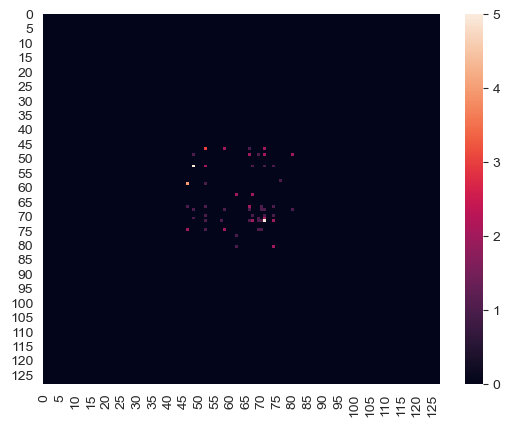

In [856]:
sns.heatmap(note_trajectory, vmin=0, vmax=5)

In [857]:
reduced = PCA(n_components=1).fit_transform(note_trajectory)

<Axes: >

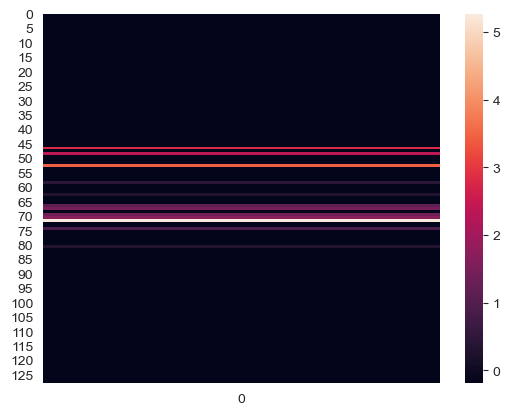

In [858]:
sns.heatmap(reduced)